# Method 3 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

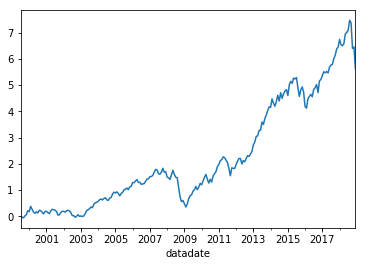

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.208380
2000-12-31   -0.022997
2001-12-31    0.005096
2002-12-31   -0.165418
2003-12-31    0.545286
2004-12-31    0.251738
2005-12-31    0.115285
2006-12-31    0.133387
2007-12-31    0.114363
2008-12-31   -0.407171
2009-12-31    0.406192
2010-12-31    0.287961
2011-12-31   -0.026914
2012-12-31    0.230242
2013-12-31    0.490816
2014-12-31    0.127664
2015-12-31   -0.018063
2016-12-31    0.085657
2017-12-31    0.199063
2018-12-31   -0.111507
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     525.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.21e-114
Time:                        12:50:17   Log-Likelihood:                 634.27
No. Observations:                 234   AIC:                            -1259.
Df Residuals:                     229   BIC:                            -1241.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.019      0.003       0.001       0.006
mktrf          0.9600      0.030     31.643      0.000       0.900       1.020
me             0.5323      0.035     15.085      0.000       0.463       0.602
ia             0.0208      0.054      0.387      0.699      -0.085       0.126
roe            0.0368      0.046      0.801      0.424      -0.054       0.127
==============================================================================
Omnibus:                       27.473   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.043
Skew:                          -0.479   Prob(JB):                     5.07e-17
Kurtosis:                       5.604   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     678.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.21e-125
Time:                        12:50:17   Log-Likelihood:                 634.27
No. Observations:                 234   AIC:                            -1259.
Df Residuals:                     229   BIC:                            -1241.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.827      0.000       0.002       0.005
mktrf          0.9600      0.038     25.000      0.000       0.885       1.035
me             0.5323      0.052     10.280      0.000       0.431       0.634
ia             0.0208      0.122      0.170      0.865      -0.219       0.261
roe            0.0368      0.062      0.589      0.556      -0.086       0.159
==============================================================================
Omnibus:                       27.473   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.043
Skew:                          -0.479   Prob(JB):                     5.07e-17
Kurtosis:                       5.604   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1088.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.20e-147
Time:                        12:50:17   Log-Likelihood:                 634.27
No. Observations:                 234   AIC:                            -1259.
Df Residuals:                     229   BIC:                            -1241.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.775      0.000       0.002       0.005
mktrf          0.9600      0.032     30.343      0.000       0.898       1.022
me             0.5323      0.054      9.928      0.000       0.427       0.637
ia             0.0208      0.121      0.171      0.864      -0.217       0.258
roe            0.0368      0.054      0.677      0.498      -0.070       0.143
==============================================================================
Omnibus:                       27.473   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.043
Skew:                          -0.479   Prob(JB):                     5.07e-17
Kurtosis:                       5.604   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     368.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.92e-107
Time:                        12:50:17   Log-Likelihood:                 620.82
No. Observations:                 234   AIC:                            -1230.
Df Residuals:                     228   BIC:                            -1209.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.046      0.003       0.001       0.006
mktrf          0.9566      0.032     29.649      0.000       0.893       1.020
smb            0.5131      0.043     12.053      0.000       0.429       0.597
hml           -0.0488      0.050     -0.973      0.332      -0.148       0.050
rmw           -0.0419      0.057     -0.738      0.461      -0.154       0.070
cma            0.1567      0.072      2.171      0.031       0.015       0.299
==============================================================================
Omnibus:                       14.347   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.075
Skew:                          -0.201   Prob(JB):                     6.57e-08
Kurtosis:                       4.797   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     650.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.02e-132
Time:                        12:50:17   Log-Likelihood:                 620.82
No. Observations:                 234   AIC:                            -1230.
Df Residuals:                     228   BIC:                            -1209.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.094      0.002       0.001       0.006
mktrf          0.9566      0.045     21.295      0.000       0.869       1.045
smb            0.5131      0.043     11.856      0.000       0.428       0.598
hml           -0.0488      0.081     -0.600      0.549      -0.208       0.111
rmw           -0.0419      0.087     -0.480      0.631      -0.213       0.129
cma            0.1567      0.144      1.089      0.276      -0.125       0.439
==============================================================================
Omnibus:                       14.347   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.075
Skew:                          -0.201   Prob(JB):                     6.57e-08
Kurtosis:                       4.797   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     935.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.07e-149
Time:                        12:50:17   Log-Likelihood:                 620.82
No. Observations:                 234   AIC:                            -1230.
Df Residuals:                     228   BIC:                            -1209.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.154      0.002       0.001       0.006
mktrf          0.9566      0.044     21.961      0.000       0.871       1.042
smb            0.5131      0.037     13.871      0.000       0.441       0.586
hml           -0.0488      0.088     -0.554      0.580      -0.222       0.124
rmw           -0.0419      0.084     -0.502      0.616      -0.206       0.122
cma            0.1567      0.157      0.999      0.318      -0.151       0.464
==============================================================================
Omnibus:                       14.347   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.075
Skew:                          -0.201   Prob(JB):                     6.57e-08
Kurtosis:                       4.797   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     492.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.68e-111
Time:                        12:50:17   Log-Likelihood:                 627.34
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.718      0.007       0.001       0.005
mktrf          1.0197      0.029     35.440      0.000       0.963       1.076
smb            0.4565      0.036     12.712      0.000       0.386       0.527
hml            0.1335      0.036      3.743      0.000       0.063       0.204
umd            0.1314      0.023      5.614      0.000       0.085       0.178
==============================================================================
Omnibus:                       26.764   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.884
Skew:                          -0.413   Prob(JB):                     1.00e-18
Kurtosis:                       5.796   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     512.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.00e-113
Time:                        12:50:17   Log-Likelihood:                 627.34
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.747      0.006       0.001       0.005
mktrf          1.0197      0.040     25.589      0.000       0.942       1.098
smb            0.4565      0.047      9.615      0.000       0.363       0.550
hml            0.1335      0.083      1.601      0.109      -0.030       0.297
umd            0.1314      0.046      2.884      0.004       0.042       0.221
==============================================================================
Omnibus:                       26.764   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.884
Skew:                          -0.413   Prob(JB):                     1.00e-18
Kurtosis:                       5.796   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     911.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.34e-139
Time:                        12:50:17   Log-Likelihood:                 627.34
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.861      0.004       0.001       0.005
mktrf          1.0197      0.034     30.391      0.000       0.954       1.085
smb            0.4565      0.039     11.828      0.000       0.381       0.532
hml            0.1335      0.089      1.492      0.136      -0.042       0.309
umd            0.1314      0.042      3.163      0.002       0.050       0.213
==============================================================================
Omnibus:                       26.764   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.884
Skew:                          -0.413   Prob(JB):                     1.00e-18
Kurtosis:                       5.796   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     215.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-52
Time:                        12:50:17   Log-Likelihood:                 301.52
No. Observations:                 120   AIC:                            -593.0
Df Residuals:                     115   BIC:                            -579.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.041      0.044       0.000       0.008
mktrf          0.9996      0.052     19.358      0.000       0.897       1.102
me             0.5377      0.051     10.543      0.000       0.437       0.639
ia             0.0792      0.080      0.991      0.324      -0.079       0.237
roe            0.0986      0.071      1.395      0.166      -0.041       0.239
==============================================================================
Omnibus:                       15.079   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.382
Skew:                          -0.602   Prob(JB):                     8.37e-06
Kurtosis:                       4.797   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     335.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-62
Time:                        12:50:18   Log-Likelihood:                 301.52
No. Observations:                 120   AIC:                            -593.0
Df Residuals:                     115   BIC:                            -579.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.273      0.001       0.002       0.006
mktrf          0.9996      0.064     15.503      0.000       0.873       1.126
me             0.5377      0.073      7.376      0.000       0.395       0.681
ia             0.0792      0.143      0.552      0.581      -0.202       0.360
roe            0.0986      0.081      1.223      0.221      -0.059       0.257
==============================================================================
Omnibus:                       15.079   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.382
Skew:                          -0.602   Prob(JB):                     8.37e-06
Kurtosis:                       4.797   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     594.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.59e-76
Time:                        12:50:18   Log-Likelihood:                 301.52
No. Observations:                 120   AIC:                            -593.0
Df Residuals:                     115   BIC:                            -579.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.942      0.000       0.002       0.006
mktrf          0.9996      0.047     21.365      0.000       0.908       1.091
me             0.5377      0.077      6.999      0.000       0.387       0.688
ia             0.0792      0.136      0.584      0.559      -0.186       0.345
roe            0.0986      0.061      1.627      0.104      -0.020       0.217
==============================================================================
Omnibus:                       15.079   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.382
Skew:                          -0.602   Prob(JB):                     8.37e-06
Kurtosis:                       4.797   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     144.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-47
Time:                        12:50:18   Log-Likelihood:                 292.63
No. Observations:                 120   AIC:                            -573.3
Df Residuals:                     114   BIC:                            -556.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.387      0.019       0.001       0.009
mktrf          0.9934      0.059     16.869      0.000       0.877       1.110
smb            0.5137      0.067      7.701      0.000       0.382       0.646
hml           -0.0838      0.082     -1.025      0.307      -0.246       0.078
rmw            0.0045      0.096      0.047      0.962      -0.186       0.195
cma            0.2641      0.106      2.501      0.014       0.055       0.473
==============================================================================
Omnibus:                        4.053   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.475
Skew:                          -0.343   Prob(JB):                        0.176
Kurtosis:                       3.473   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     437.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-72
Time:                        12:50:18   Log-Likelihood:                 292.63
No. Observations:                 120   AIC:                            -573.3
Df Residuals:                     114   BIC:                            -556.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.972      0.003       0.002       0.008
mktrf          0.9934      0.089     11.195      0.000       0.820       1.167
smb            0.5137      0.060      8.587      0.000       0.396       0.631
hml           -0.0838      0.138     -0.609      0.543      -0.354       0.186
rmw            0.0045      0.152      0.030      0.976      -0.293       0.302
cma            0.2641      0.174      1.519      0.129      -0.077       0.605
==============================================================================
Omnibus:                        4.053   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.475
Skew:                          -0.343   Prob(JB):                        0.176
Kurtosis:                       3.473   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     684.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.02e-83
Time:                        12:50:18   Log-Likelihood:                 292.63
No. Observations:                 120   AIC:                            -573.3
Df Residuals:                     114   BIC:                            -556.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.001      3.645      0.000       0.002       0.008
mktrf          0.9934      0.090     11.016      0.000       0.817       1.170
smb            0.5137      0.052      9.853      0.000       0.412       0.616
hml           -0.0838      0.152     -0.551      0.582      -0.382       0.214
rmw            0.0045      0.162      0.028      0.978      -0.314       0.323
cma            0.2641      0.183      1.439      0.150      -0.096       0.624
==============================================================================
Omnibus:                        4.053   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.475
Skew:                          -0.343   Prob(JB):                        0.176
Kurtosis:                       3.473   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     196.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.92e-50
Time:                        12:50:18   Log-Likelihood:                 296.62
No. Observations:                 120   AIC:                            -583.2
Df Residuals:                     115   BIC:                            -569.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.721      0.008       0.001       0.009
mktrf          1.0554      0.047     22.272      0.000       0.962       1.149
smb            0.4279      0.054      7.930      0.000       0.321       0.535
hml            0.1589      0.054      2.940      0.004       0.052       0.266
umd            0.1505      0.033      4.516      0.000       0.084       0.216
==============================================================================
Omnibus:                       18.054   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.701
Skew:                          -0.692   Prob(JB):                     3.55e-07
Kurtosis:                       5.006   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     286.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.43e-59
Time:                        12:50:18   Log-Likelihood:                 296.62
No. Observations:                 120   AIC:                            -583.2
Df Residuals:                     115   BIC:                            -569.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      3.414      0.001       0.002       0.008
mktrf          1.0554      0.061     17.328      0.000       0.936       1.175
smb            0.4279      0.073      5.827      0.000       0.284       0.572
hml            0.1589      0.101      1.571      0.116      -0.039       0.357
umd            0.1505      0.053      2.821      0.005       0.046       0.255
==============================================================================
Omnibus:                       18.054   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.701
Skew:                          -0.692   Prob(JB):                     3.55e-07
Kurtosis:                       5.006   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     744.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-81
Time:                        12:50:18   Log-Likelihood:                 296.62
No. Observations:                 120   AIC:                            -583.2
Df Residuals:                     115   BIC:                            -569.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.001      4.489      0.000       0.003       0.008
mktrf          1.0554      0.046     22.775      0.000       0.965       1.146
smb            0.4279      0.061      7.019      0.000       0.308       0.547
hml            0.1589      0.107      1.479      0.139      -0.052       0.369
umd            0.1505      0.041      3.631      0.000       0.069       0.232
==============================================================================
Omnibus:                       18.054   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.701
Skew:                          -0.692   Prob(JB):                     3.55e-07
Kurtosis:                       5.006   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     543.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.20e-71
Time:                        12:50:18   Log-Likelihood:                 367.34
No. Observations:                 114   AIC:                            -724.7
Df Residuals:                     109   BIC:                            -711.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.034      0.003       0.001       0.005
mktrf          0.9438      0.029     32.545      0.000       0.886       1.001
me             0.5030      0.045     11.233      0.000       0.414       0.592
ia            -0.2116      0.062     -3.406      0.001      -0.335      -0.088
roe           -0.1871      0.055     -3.428      0.001      -0.295      -0.079
==============================================================================
Omnibus:                        0.457   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.494
Skew:                           0.147   Prob(JB):                        0.781
Kurtosis:                       2.868   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     633.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-74
Time:                        12:50:18   Log-Likelihood:                 367.34
No. Observations:                 114   AIC:                            -724.7
Df Residuals:                     109   BIC:                            -711.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.360      0.018       0.001       0.005
mktrf          0.9438      0.026     35.929      0.000       0.892       0.995
me             0.5030      0.042     11.888      0.000       0.420       0.586
ia            -0.2116      0.073     -2.898      0.004      -0.355      -0.068
roe           -0.1871      0.072     -2.608      0.009      -0.328      -0.046
==============================================================================
Omnibus:                        0.457   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.494
Skew:                           0.147   Prob(JB):                        0.781
Kurtosis:                       2.868   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     907.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.13e-82
Time:                        12:50:18   Log-Likelihood:                 367.34
No. Observations:                 114   AIC:                            -724.7
Df Residuals:                     109   BIC:                            -711.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      1.993      0.046    4.88e-05       0.006
mktrf          0.9438      0.025     38.505      0.000       0.896       0.992
me             0.5030      0.040     12.685      0.000       0.425       0.581
ia            -0.2116      0.078     -2.719      0.007      -0.364      -0.059
roe           -0.1871      0.069     -2.730      0.006      -0.321      -0.053
==============================================================================
Omnibus:                        0.457   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.494
Skew:                           0.147   Prob(JB):                        0.781
Kurtosis:                       2.868   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     528.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-74
Time:                        12:50:18   Log-Likelihood:                 378.50
No. Observations:                 114   AIC:                            -745.0
Df Residuals:                     108   BIC:                            -728.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.280      0.025       0.000       0.004
mktrf          0.9639      0.025     38.254      0.000       0.914       1.014
smb            0.4656      0.041     11.383      0.000       0.385       0.547
hml           -0.0634      0.052     -1.215      0.227      -0.167       0.040
rmw           -0.3256      0.064     -5.097      0.000      -0.452      -0.199
cma           -0.1408      0.081     -1.736      0.085      -0.301       0.020
==============================================================================
Omnibus:                        1.811   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.468
Skew:                           0.274   Prob(JB):                        0.480
Kurtosis:                       3.092   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     526.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.21e-74
Time:                        12:50:18   Log-Likelihood:                 378.50
No. Observations:                 114   AIC:                            -745.0
Df Residuals:                     108   BIC:                            -728.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.670      0.095      -0.000       0.004
mktrf          0.9639      0.024     40.908      0.000       0.918       1.010
smb            0.4656      0.040     11.502      0.000       0.386       0.545
hml           -0.0634      0.039     -1.618      0.106      -0.140       0.013
rmw           -0.3256      0.059     -5.538      0.000      -0.441      -0.210
cma           -0.1408      0.070     -2.010      0.044      -0.278      -0.003
==============================================================================
Omnibus:                        1.811   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.468
Skew:                           0.274   Prob(JB):                        0.480
Kurtosis:                       3.092   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     687.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.81e-80
Time:                        12:50:18   Log-Likelihood:                 378.50
No. Observations:                 114   AIC:                            -745.0
Df Residuals:                     108   BIC:                            -728.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.441      0.150      -0.001       0.005
mktrf          0.9639      0.024     40.795      0.000       0.918       1.010
smb            0.4656      0.038     12.396      0.000       0.392       0.539
hml           -0.0634      0.037     -1.703      0.089      -0.136       0.010
rmw           -0.3256      0.059     -5.530      0.000      -0.441      -0.210
cma           -0.1408      0.072     -1.948      0.051      -0.282       0.001
==============================================================================
Omnibus:                        1.811   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.468
Skew:                           0.274   Prob(JB):                        0.480
Kurtosis:                       3.092   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     513.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-69
Time:                        12:50:18   Log-Likelihood:                 364.20
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.892      0.374      -0.001       0.003
mktrf          1.0031      0.028     35.507      0.000       0.947       1.059
smb            0.5292      0.044     12.013      0.000       0.442       0.616
hml           -0.0071      0.045     -0.155      0.877      -0.097       0.083
umd            0.0597      0.034      1.745      0.084      -0.008       0.128
==============================================================================
Omnibus:                        0.335   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.846   Jarque-Bera (JB):                0.502
Skew:                           0.014   Prob(JB):                        0.778
Kurtosis:                       2.676   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     451.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.82e-67
Time:                        12:50:18   Log-Likelihood:                 364.20
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.660      0.509      -0.002       0.004
mktrf          1.0031      0.029     35.051      0.000       0.947       1.059
smb            0.5292      0.039     13.506      0.000       0.452       0.606
hml           -0.0071      0.041     -0.172      0.863      -0.087       0.073
umd            0.0597      0.020      2.938      0.003       0.020       0.100
==============================================================================
Omnibus:                        0.335   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.846   Jarque-Bera (JB):                0.502
Skew:                           0.014   Prob(JB):                        0.778
Kurtosis:                       2.676   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     628.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.73e-74
Time:                        12:50:18   Log-Likelihood:                 364.20
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.601      0.548      -0.002       0.004
mktrf          1.0031      0.028     36.078      0.000       0.949       1.058
smb            0.5292      0.033     16.114      0.000       0.465       0.594
hml           -0.0071      0.037     -0.192      0.848      -0.079       0.065
umd            0.0597      0.019      3.159      0.002       0.023       0.097
==============================================================================
Omnibus:                        0.335   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.846   Jarque-Bera (JB):                0.502
Skew:                           0.014   Prob(JB):                        0.778
Kurtosis:                       2.676   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""